<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ESA - Black Sea Deoxygenation Emulator</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [4]:
# ----------
# Librairies
# ----------
import os
import sys
import cv2
import xarray
import random
import dawgz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Dawgz (jobs //)
from dawgz import job, schedule

# -------------------
# Librairies (Custom)
# -------------------
# Adding path to source folder to load custom modules
sys.path.insert(1, '../src/debs/')
sys.path.insert(1, '../scripts/')

# Loading libraries
from dataset              import BlackSea_Dataset
from dataloader           import BlackSea_Dataloader
from dataset_evolution    import BlackSea_Dataset_Evolution
from dataset_distribution import BlackSea_Dataset_Distribution
from tools                import *

# -------
# Jupyter
# -------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to the .py directory
%cd ../src/debs/

[Errno 2] No such file or directory: '../src/debs/'
/Users/vikvador/Documents/esa/ESA---Black-Sea-Deoxygenation/src/debs


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Scripts</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Analyzing the data (1):
%run script_distribution.py --start_year        0 \
                            --end_year          0 \
                            --start_month       1 \
                            --end_month         2 \
                            --dawgz         False

In [ ]:
# Analyzing the data (2):
%run script_evolution.py --start_year        0 \
                         --end_year          0 \
                         --start_month       1 \
                         --end_month         2 \
                         --dawgz         False

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [5]:
# -----------------
#    Parameters
# -----------------
#
# Time window
month_starting = 1
month_ending   = 1
year_starting  = 0
year_ending    = 0

# Maximum depth observed for oxygen, what is left is masked [m] (Note: To observe only the continental shelf set it to ~120m).
depth_max_oxygen = None

# ------------------
#  Loading the data
# ------------------
# Datasets !
Dataset_physical = BlackSea_Dataset(year_start = year_starting, year_end = year_ending, month_start = month_starting,  month_end = month_ending, variable = "grid_T")
Dataset_bio      = BlackSea_Dataset(year_start = year_starting, year_end = year_ending, month_start = month_starting,  month_end = month_ending, variable = "ptrc_T")

# Loading the different field values
data_oxygen        = Dataset_bio.get_oxygen_bottom(depth = depth_max_oxygen)
data_temperature   = Dataset_physical.get_temperature()
data_salinity      = Dataset_physical.get_salinity()
data_chlorophyll   = Dataset_bio.get_chlorophyll()
data_kshort        = Dataset_bio.get_light_attenuation_coefficient_short_waves()
data_klong         = Dataset_bio.get_light_attenuation_coefficient_long_waves()

# Loading the black sea mask
BS_mask = Dataset_physical.get_blacksea_mask()

# --------------------
#  Preparing the data
# --------------------
# Loading the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature, data_salinity, data_chlorophyll, data_kshort, data_klong],
                                 y = data_oxygen,
                              mask = BS_mask,
                              mode = "temporal",
                        resolution = 64,
                            window = 7,
                        window_oxy = 7)

# Rertieving the datasets
ds_train      = BSD_loader.get_dataloader("train")
ds_validation = BSD_loader.get_dataloader("validation")
ds_test       = BSD_loader.get_dataloader("test")

Input shape:  2 (14, 258, 258) 
Output shape:  (14, 258, 258)
Input shape:  torch.Size([20, 4, 128, 128]) 
Output shape:  torch.Size([20, 1, 128, 128])


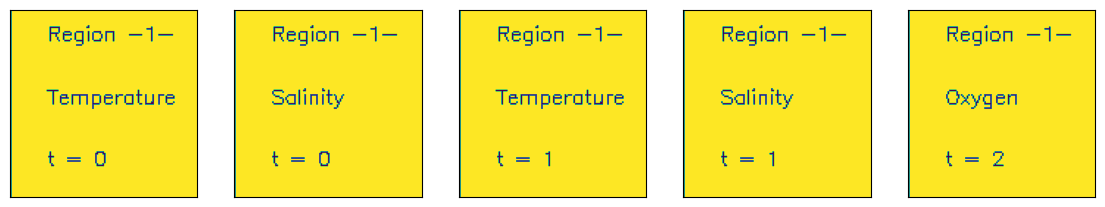

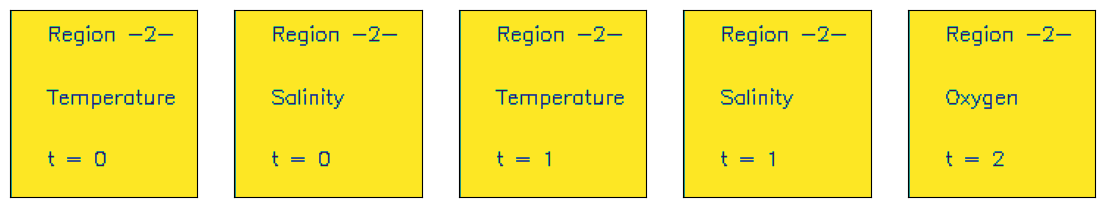

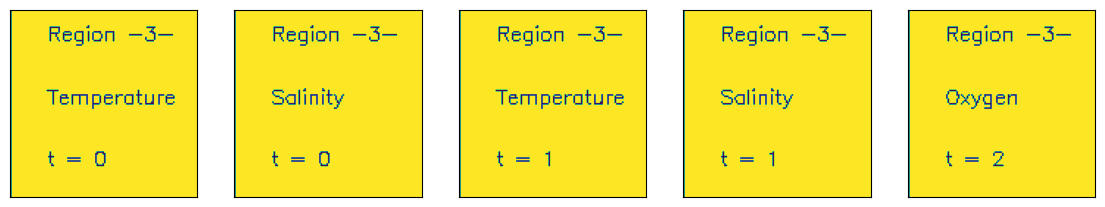

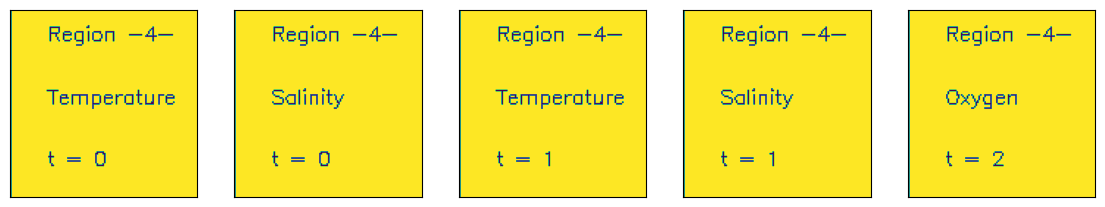

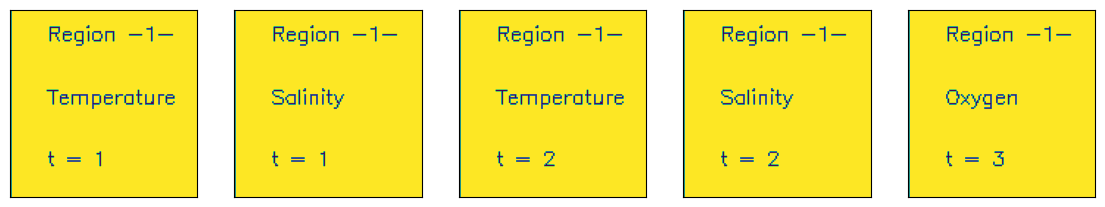

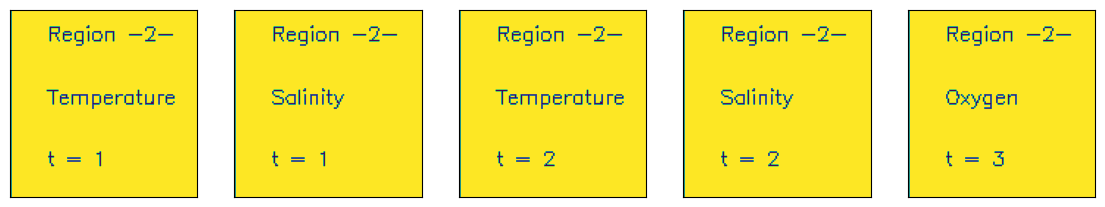

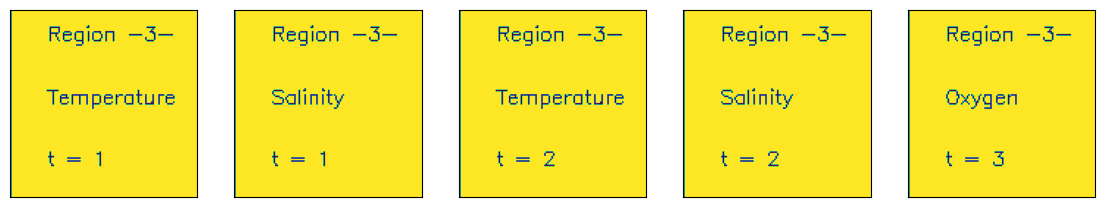

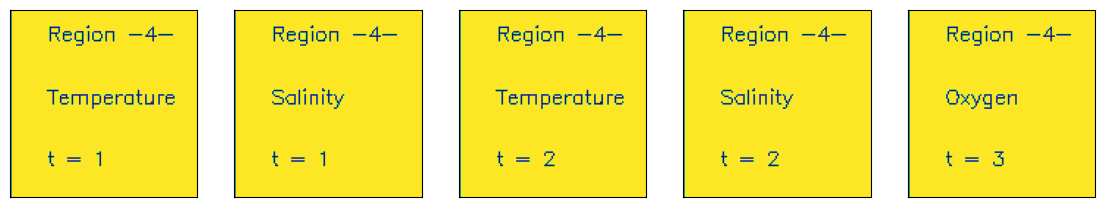

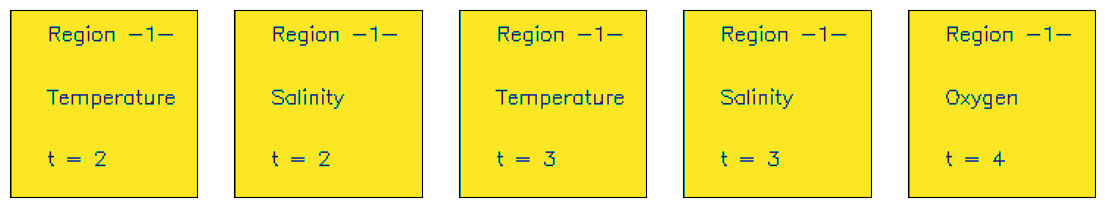

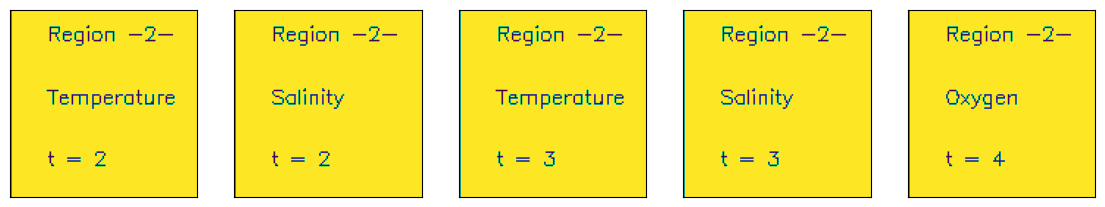

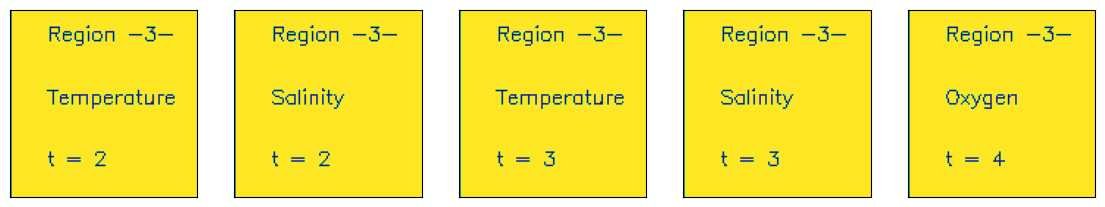

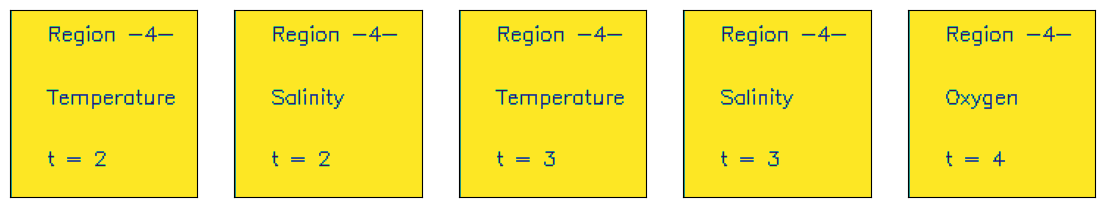

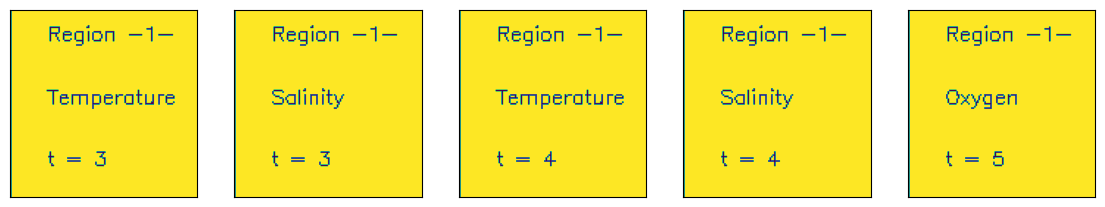

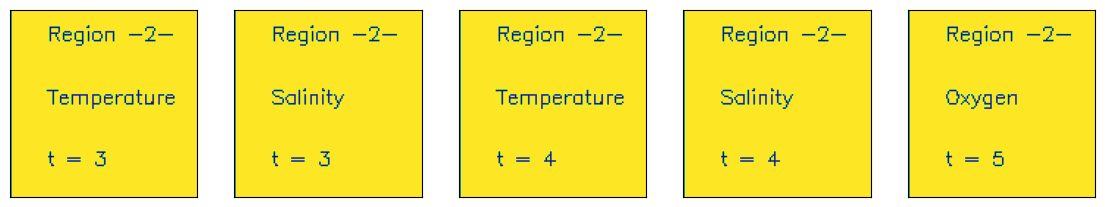

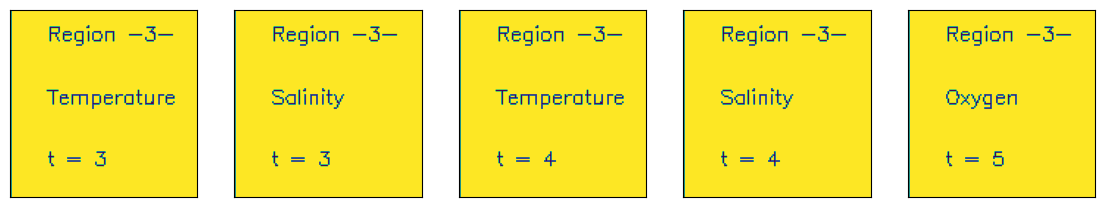

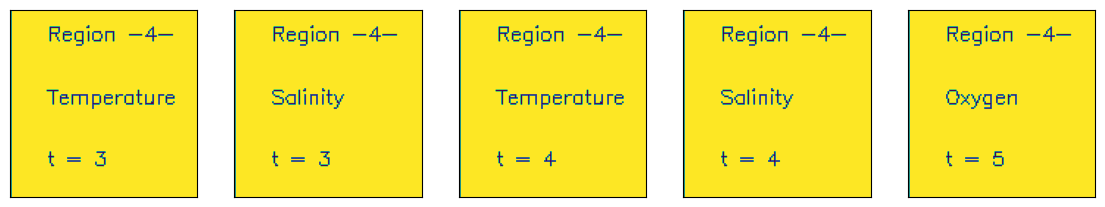

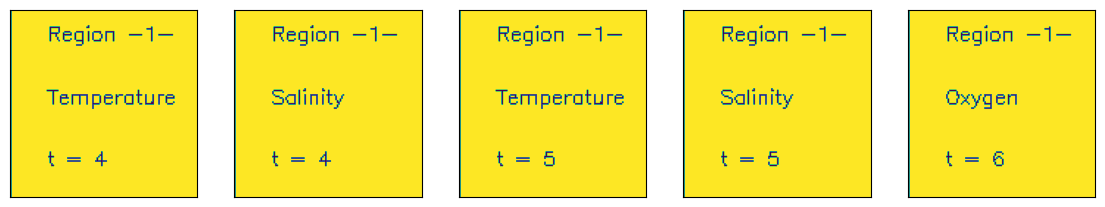

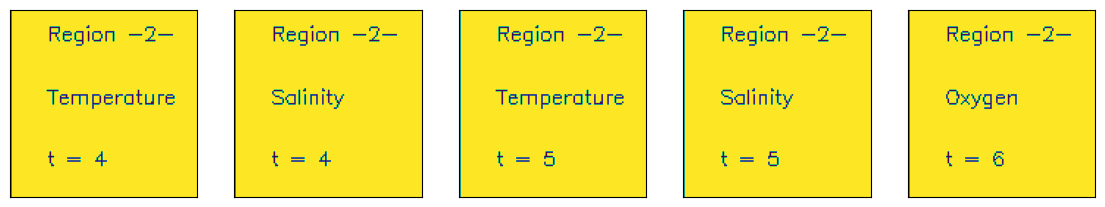

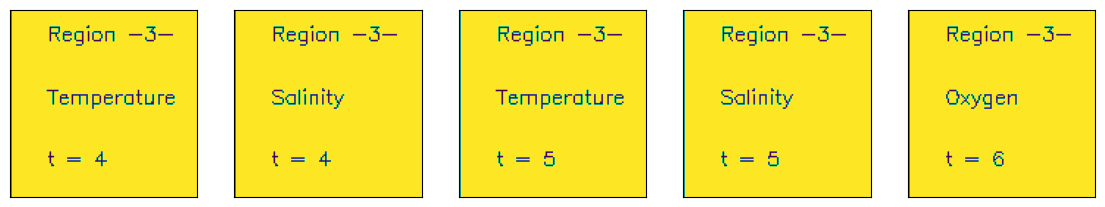

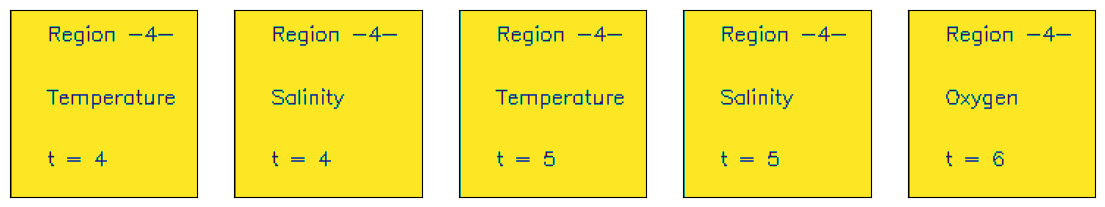

In [79]:
# --------------------
#       TESTING
# --------------------
#
# Number of input variables
var_inputs = 2

# Window for the input
win_in = 2

# Window for the oxygen
win_out = 1

# Number of days
days = 14



# --------------------
#      GENERATING
# --------------------
# Generating fake data
fake_data_physical_variables = generateFakeDataset(resolution = 128, number_of_variables = var_inputs, number_of_samples=days)
fake_data_physical_oxygen    = generateFakeDataset(resolution = 128, number_of_variables = 1, number_of_samples=days, oxygen = True)

# Creation of the dataloaders
BSD_loader_fake_spatial = BlackSea_Dataloader(x = fake_data_physical_variables,
                                              y = fake_data_physical_oxygen[0],
                                           mask = np.ones(shape = (258, 258)),
                                           mode = "spatial",
                                     resolution = 128,
                                        window = win_in,
                                    window_oxy = win_out)

BSD_loader_fake_temporal = BlackSea_Dataloader(x = fake_data_physical_variables,
                                               y = fake_data_physical_oxygen[0],
                                            mask = np.ones(shape = (258, 258)),
                                            mode = "temporal",
                                      resolution = 128,
                                          window = win_in,
                                      window_oxy = win_out)


# OK
"""
for i in range(fake_data_physical_variables[0].shape[0]):

    plt.figure(figsize=(5, 5))
    plt.imshow(fake_data_physical_variables[1][i, :, :])
"""

# --------------------------------------------------------------------------------
#                                       SPATIAL
# --------------------------------------------------------------------------------
"""
for x, y in BSD_loader_fake_spatial.get_dataloader("train"):

    # Initial shapes
    print("Input shape: ", len(fake_data_physical_variables), fake_data_physical_variables[0].shape, "\nOutput shape: ", fake_data_physical_oxygen[0].shape)

    # Shapes (dataloader)
    print("Input shape: ", x.shape, "\nOutput shape: ", y.shape)

    # The total number of samples is
    # [Number of timesteps - number of input days (window) - number of output days (window_oxygen) ] * number of regions
    #
    # Tests
    #
    # Number of variables
    assert x.shape[1] == var_inputs * win_in

    # Number of outputs
    assert y.shape[1] == win_out

    # Number of samples (must be divided by 2 for the validation and test)
    assert x.shape[0] == (fake_data_physical_variables[0].shape[0] - win_in - win_out) * int(256/128)

    # Checking that I have all the timesteps
    #
    # Looping over all the time steps
    for i in range(x.shape[0]):

        # Showing as a subplots the input and output pairs
        plt.figure(figsize=(14, 14))

        for j in range(var_inputs * win_in):
            plt.subplot(1, var_inputs * win_in + win_out, j+1)

            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x[i, j, :, :])

        for j in range(win_out):
            plt.subplot(1, var_inputs * win_in + win_out, var_inputs * win_in + j+1)
            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            plt.imshow(y[i, j, :, :])

    # Idea check the validity using a trehsold to create a 1 0 matrix for comparison (otherwise it will  bug since you have normalized the data)

"""
# --------------------------------------------------------------------------------
#                                       SPATIAL
# --------------------------------------------------------------------------------
for x, y in BSD_loader_fake_temporal.get_dataloader("train"):

    # Initial shapes
    print("Input shape: ", len(fake_data_physical_variables), fake_data_physical_variables[0].shape, "\nOutput shape: ", fake_data_physical_oxygen[0].shape)

    # Shapes (dataloader)
    print("Input shape: ", x.shape, "\nOutput shape: ", y.shape)

    # Checking that I have all the regions
    #
    # Looping over all the time steps
    for i in range(x.shape[0]):

        # Showing as a subplots the input and output pairs
        plt.figure(figsize=(14, 14))

        for j in range(var_inputs * win_in):
            plt.subplot(1, var_inputs * win_in + win_out, j+1)

            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(x[i, j, :, :])

        for j in range(win_out):
            plt.subplot(1, var_inputs * win_in + win_out, var_inputs * win_in + j+1)
            # Removing labels and tickz
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            plt.imshow(y[i, j, :, :])


In [ ]:
print(y[0, 0])